In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# define model
def vehicle(v,t,u,load):
    # inputs
    #  v    = vehicle velocity (m/s)
    #  t    = time (sec)
    #  u    = gas pedal position (-50% to 100%)
    #  load = passenger load + cargo (kg)
    Cd = 0.24    # drag coefficient
    rho = 1.225  # air density (kg/m^3)
    A = 5.0      # cross-sectional area (m^2)
    Fp = 30      # thrust parameter (N/%pedal)
    m = 500      # vehicle mass (kg)
    # calculate derivative of the velocity
    dv_dt = (1.0/(m+load)) * (Fp*u - 0.5*rho*Cd*A*v**2)
    return dv_dt

tf = 60.0                 # final time for simulation
nsteps = 61               # number of time steps
delta_t = tf/(nsteps-1)   # how long is each time step?
ts = np.linspace(0,tf,nsteps) # linearly spaced time vector

# simulate step test operation
step = np.zeros(nsteps) # u = valve % open
step[11:] = 50.0       # step up pedal position
# passenger(s) + cargo load
load = 200.0 # kg
# velocity initial condition
v0 = 0.0
# for storing the results
vs = np.zeros(nsteps)

# simulate with ODEINT
for i in range(nsteps-1):
    u = step[i]
    # clip inputs to -50% to 100%
    if u >= 100.0:
        u = 100.0
    if u <= -50.0:
        u = -50.0
    v = odeint(vehicle,v0,[0,delta_t],args=(u,load))
    v0 = v[-1]   # take the last value
    vs[i+1] = v0 # store the velocity for plotting

# create linear interpolation of the u data versus time
vf = interp1d(ts,vs)


# FOPDT Model
def fopdt(x,t,vf,Kp,taup,thetap):
    try:
        if (t-thetap) <0:
            vm = vf(0.0)
        else:
            vm = vf(t-thetap)
    except:
        vm = 0
    dxdt = (-x+Kp*vm)/taup
    return dxdt

def sim_model(x):
    Kp = x[0]
    taup = x[1]
    thetap = x[2]
    xp0 = vs[0]
    xs = np.zeros(len(ts))
    xs[0] = xp0
    
    for i in range(len(ts)-1):
        delta_t = [ts[i],ts[i+1]]
        y = odeint(fopdt,xp0,delta_t,args=(vf,Kp,taup,thetap))
        xp0 = y[-1]
        xs[i+1] = xp0
    return xs

def objective(x):
    xs = sim_model(x)
    obj = 0.0
    for i in range(len(xs)):
        obj = obj + (xs[i]-vs[i])**2
    return obj

#initial guess
x0 = np.zeros(3)
x0[0] = 1.0356  # kp
x0[1] = 0.01  # taup
x0[2] = 0.9883  # thetap

# show initial objective
print('Initial SSE Objective: ' + str(objective(x_i)))

# optimize Km,taum,thetam
# bounds on variables
bnds = ((-1.0e10,1.0e10),(0.01,1.0e10),(0.0,1.0e10))
solution = minimize(objective, x_i,method='SLSQP',bounds=bnds)
print(solution)
x = solution.x

vm1 = sim_model(x0)
vm2 = sim_model(x)
plt.figure()
plt.plot(ts,vm1,'b-',linewidth = 3,label = 'Initial Guess')
plt.plot(ts,vm2,'r--',linewidth = 3,label = 'Optimized')
plt.plot(ts,vs,'k-',linewidth = 3,label = 'Model Data')
plt.legend(loc='best')
plt.show()



Initial SSE Objective: 1881.95524607
     fun: 68.794686601704655
     jac: array([ 1992.85038567,  -173.30714798,  -110.75233078,     0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 1.03563038,  0.01000011,  0.98832845])


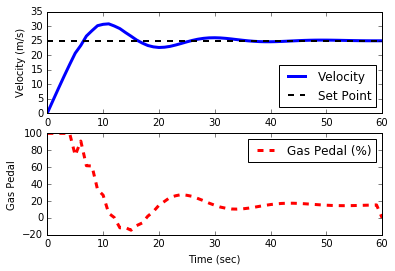

In [70]:
# Control Velocity
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
%matplotlib inline

# define model
def vehicle(v,t,u,load):
    # inputs
    #  v    = vehicle velocity (m/s)
    #  t    = time (sec)
    #  u    = gas pedal position (-50% to 100%)
    #  load = passenger load + cargo (kg)
    Cd = 0.24    # drag coefficient
    rho = 1.225  # air density (kg/m^3)
    A = 5.0      # cross-sectional area (m^2)
    Fp = 30      # thrust parameter (N/%pedal)
    m = 500      # vehicle mass (kg)
    # calculate derivative of the velocity
    dv_dt = (1.0/(m+load)) * (Fp*u - 0.5*rho*Cd*A*v**2)
    return dv_dt

tf = 60.0                 # final time for simulation
nsteps = 61               # number of time steps
delta_t = tf/(nsteps-1)   # how long is each time step?
ts = np.linspace(0,tf,nsteps) # linearly spaced time vector



    

# simulate step test operation
u = np.zeros(nsteps) # u = valve % open
# u[11:] = 50.0       # step up pedal position
# passenger(s) + cargo load
load = 200.0 # kg
# velocity initial condition
v0 = 0.0
# for storing the results
vs = np.zeros(nsteps)
SP = np.ones(nsteps)*25.0 # set point 25m/s
e = np.zeros(nsteps)
integral = 0.0
derive = 0.0

# PID Tuning
Kc = 4.0
tauI = 0.9
tauD = 4.0

# simulate with ODEINT
for i in range(nsteps-1):
    e[i] = SP[i] - v0
    integral = integral + e[i]*(ts[i+1]-ts[i])
    if i>=1:
        derive = (vs[i]-vs[i-1])/delta_t
    u[i] = u[0]+Kc*e[i]+Kc/tauI*integral - Kc*tauD*derive
    # clip inputs to -50% to 100%
    if u[i] >= 100.0:
        u[i] = 100.0
        integral = integral - e[i]*(ts[i+1]-ts[i])
    if u[i] <= -50.0:
        u[i] = -50.0
        integral = integral - e[i]*(ts[i+1]-ts[i])
    v = odeint(vehicle,v0,[0,delta_t],args=(u[i],load))
    v0 = v[-1]   # take the last value
    vs[i+1] = v0 # store the velocity for plotting

# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(ts,vs,'b-',linewidth=3)
plt.plot([0,tf],[25,25],'k--',linewidth=2)
plt.ylabel('Velocity (m/s)')
plt.legend(['Velocity','Set Point'],loc=4)
plt.subplot(2,1,2)
plt.plot(ts,u,'r--',linewidth=3)
plt.ylabel('Gas Pedal')    
plt.legend(['Gas Pedal (%)'])
plt.xlabel('Time (sec)')
plt.show()